In [2]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import skforecast
print(skforecast.__version__)

/home/joaquin/Documents/GitHub/skforecast
0.18.0


In [6]:
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset
import stumpy
import numpy as np


In [7]:
data = fetch_dataset('bike_sharing')
data.head(3)

╭───────────────────────────────── bike_sharing ──────────────────────────────────╮
│ Description:                                                                    │
│ Hourly usage of the bike share system in the city of Washington D.C. during the │
│ years 2011 and 2012. In addition to the number of users per hour, information   │
│ about weather conditions and holidays is available.                             │
│                                                                                 │
│ Source:                                                                         │
│ Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.   │
│ https://doi.org/10.24432/C5W894.                                                │
│                                                                                 │
│ URL:                                                                            │
│ https://raw.githubusercontent.com/skforecast/skforecast-                        │
│ datasets/main/data/bike_sharing_dataset_clean.csv                               │
│                                                                                 │
│ Shape: 17544 rows x 11 columns                                                  │
╰─────────────────────────────────────────────────────────────────────────────────╯

,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
date_time,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,clear,9.84,14.395,81.0,0.0,16.0,1,0,5
2011-01-01 01:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0,40.0,1,1,5
2011-01-01 02:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0,32.0,1,2,5


Best match starts at index: 16544, Distance: 0.0000, Match Quality (Correlation): 1.0000


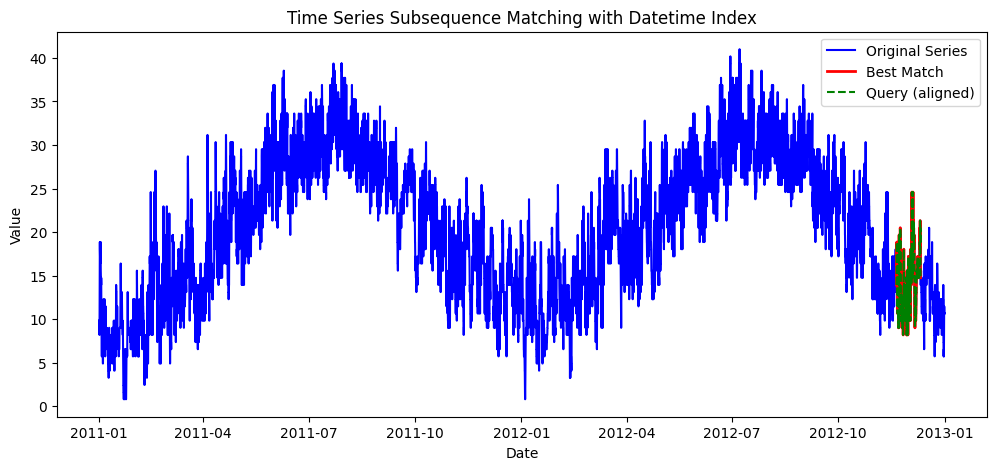

In [9]:
import pandas as pd
import numpy as np
import stumpy
import matplotlib.pyplot as plt

def find_most_similar_subsequence(long_series: pd.Series, query: pd.Series):
    """
    Finds the subsequence in a pandas Series most similar to the query Series.
    
    Parameters:
        long_series (pd.Series): Original time series with datetime index.
        query (pd.Series): Short query series with datetime index.
        
    Returns:
        best_index (int): Starting index of the best match in long_series.
        best_distance (float): Distance of the best match.
        best_subsequence (pd.Series): Matched subsequence as a pandas Series with original datetime index.
    """
    long_values = long_series.values.astype(float)
    query_values = query.values.astype(float)
    
    m = len(query_values)
    
    # Compute distance profile using MASS
    distance_profile = stumpy.mass(query_values, long_values, normalize=False)
    
    best_index = np.argmin(distance_profile)
    best_distance = distance_profile[best_index]
    
    best_subsequence = long_series.iloc[best_index:best_index + m]
    
    # Compute correlation (match quality)
    segment_values = best_subsequence.values
    segment_norm = (segment_values - np.mean(segment_values)) / np.std(segment_values)
    match_quality = np.corrcoef(query_values, segment_norm)[0, 1]
    
    return best_index, best_distance, best_subsequence, match_quality

# Example with pandas Series
long_series = data["temp"]
#query = X_new.loc[chunck_start:chunck_end, 'temp']
query = data["temp"].iloc[-1000:-500].copy()
# Find most similar subsequence
index, dist, segment, quality = find_most_similar_subsequence(long_series, query)
print(f'Best match starts at index: {index}, Distance: {dist:.4f}, Match Quality (Correlation): {quality:.4f}')

# Plot
plt.figure(figsize=(12, 5))
plt.plot(long_series.index, long_series.values, label='Original Series', color='blue')
plt.plot(segment.index, segment.values, label='Best Match', color='red', linewidth=2)
# Align query for visualization
#aligned_query = query.values + segment.values.mean() - query.values.mean()
# plt.plot(segment.index, aligned_query, label='Query (aligned)', color='green', linestyle='--')
plt.plot(segment.index, query, label='Query (aligned)', color='green', linestyle='--')
plt.title('Time Series Subsequence Matching with Datetime Index')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [10]:
import plotly.graph_objects as go

# Example with pandas Series
long_series = data["temp"]
#query = X_new.loc[chunck_start:chunck_end, 'temp']
query = data["temp"].iloc[-1000:-500].copy().iloc[::-1]
# Find most similar subsequence
index, dist, segment, quality = find_most_similar_subsequence(long_series, query)
print(f'Best match starts at index: {index}, Distance: {dist:.4f}, Match Quality (Correlation): {quality:.4f}')

# Plot using Plotly
fig = go.Figure()

# Add original series
fig.add_trace(go.Scatter(
    x=long_series.index,
    y=long_series.values,
    mode='lines',
    name='Original Series',
    line=dict(color='blue')
))

# Add best match
fig.add_trace(go.Scatter(
    x=segment.index,
    y=segment.values,
    mode='lines',
    name='Best Match',
    line=dict(color='red', width=2)
))

# Add query (aligned)
fig.add_trace(go.Scatter(
    x=segment.index,
    y=query,
    mode='lines',
    name='Query (aligned)',
    line=dict(color='green', dash='dash')
))

# Update layout
fig.update_layout(
    title='Time Series Subsequence Matching with Datetime Index',
    xaxis_title='Date',
    yaxis_title='Value',
    width=1200,
    height=500
)

fig.show()

Best match starts at index: 16349, Distance: 75.5113, Match Quality (Correlation): 0.5240
